## Julian Stennett | CGS4144 Bioinformatics | Assignment 2

In [115]:
import pandas as pd
import mygene
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LinearDiscriminantAnalysis
from scipy import stats

#### Loading Data and Gene Name Conversion for Pig Gene Expression Data

##### This script loads gene expression data, extracts Ensembl IDs from the 'Gene' column, and queries the MyGene.info API to retrieve corresponding Hugo gene names for pigs. The original DataFrame is then updated to replace Ensembl IDs with their respective gene symbols, ensuring that any missing symbols are filled with the original IDs.

In [14]:
# Load your data
df = pd.read_csv('ERP105973/ERP105973.tsv', sep='\t', header=0)

# Extract the list of Ensembl IDs from the 'Gene' column
ensembl_ids = df['Gene'].tolist()

# Initialize mygene client
mg = mygene.MyGeneInfo()

# Query Ensembl IDs to get Hugo gene names for pigs
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='pig')

# Convert the query result into a DataFrame
gene_df = pd.DataFrame(gene_info)


# Check if 'symbol' column exists
if 'symbol' in gene_df.columns:
    # Fill missing values with the original Ensembl ID
    gene_df['symbol'].fillna(gene_df['query'], inplace=True)

    # Remove duplicates based on 'query'
    gene_df = gene_df.drop_duplicates(subset='query')

    # Merge the original DataFrame with the new gene symbol DataFrame
    df = df.merge(gene_df[['query', 'symbol']], left_on='Gene', right_on='query', how='left')

    # Replace the 'Gene' column with 'symbol'
    df['Gene'] = df['symbol'].combine_first(df['Gene'])

    # Drop the extra 'query' and 'symbol' columns
    df.drop(columns=['query', 'symbol'], inplace=True)

else:
    print("The 'symbol' column does not exist in gene_df. Check the output for further information.")


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-25549...done.
Finished.
16 input query terms found dup hits:
	[('ENSSSCG00000007733', 2), ('ENSSSCG00000011068', 2), ('ENSSSCG00000016711', 2), ('ENSSSCG000000259
6062 input query terms found no hit:
	['ENSSSCG00000000057', 'ENSSSCG00000000073', 'ENSSSCG00000000083', 'ENSSSCG000000

/var/folders/nf/bmcsp4f521g7q_d4f_9jkgx40000gn/T/ipykernel_21862/3189479478.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gene_df['symbol'].fillna(gene_df['query'], inplace=True)


In [63]:
df.head()

,Gene,ERR2239979,ERR2239980,ERR2239981,ERR2239982,ERR2239983,ERR2239984,ERR2239985,ERR2239986,ERR2239987,...,ERR2240041,ERR2240042,ERR2240043,ERR2240044,ERR2240045,ERR2240046,ERR2240047,ERR2240048,ERR2240049,ERR2240050
0,GTSE1,-0.974780,-1.098466,-0.096769,-0.810719,0.810700,0.781491,-0.063221,0.571952,1.025183,...,-0.395163,1.719113,-0.201687,-0.950950,0.787939,2.233017,1.397065,-0.739792,0.203013,0.617727
1,TTC38,-0.303871,1.027110,0.212347,1.178167,1.367981,0.660345,-0.226611,-0.531966,-0.797222,...,0.143982,0.270656,0.585510,0.434997,1.091644,1.599875,1.342389,0.033841,1.012071,1.357558
2,CDPF1,-0.310751,-0.421228,-0.780650,-0.376613,-0.861849,-0.669572,0.076419,1.241911,1.137093,...,-0.568306,-0.894833,-0.057907,-0.994663,0.596338,0.283011,0.900497,-0.352856,-0.600167,0.047482
3,PPARA,0.627432,0.318908,-0.161431,0.859589,-0.798180,-0.669031,-1.449027,0.033215,0.671936,...,-0.016897,3.868562,1.548431,-0.407325,-1.493562,0.159849,1.554370,0.065728,0.985354,0.374793
4,TRMU,-0.280341,1.518008,0.333855,0.096288,-0.202121,0.789890,0.733772,-0.162580,0.113229,...,-0.206097,0.229155,-0.107253,1.584477,1.460494,-0.191817,-0.380415,0.370317,1.307943,0.807296


#### Principal Component Analysis (PCA) Preparation

##### This section prepares the data for Principal Component Analysis (PCA) by excluding the 'Gene' column and ensuring all remaining data is numeric. The data is standardized using `StandardScaler`, and PCA is performed to reduce the dimensionality to two principal components for visualization. Finally, a DataFrame is created to store the PCA results along with the corresponding gene names for labeling.


In [120]:
# Prepare data for PCA (only keep numeric columns)
data_for_pca = df.drop(columns=['Gene'])  # Exclude the Gene column
data_for_pca = data_for_pca.apply(pd.to_numeric, errors='coerce')  # Ensure all data is numeric
data_for_pca = data_for_pca.fillna(0)  # Fill NaNs with 0s if necessary

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_pca)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Gene'] = df['Gene']  # Add gene names back for labeling

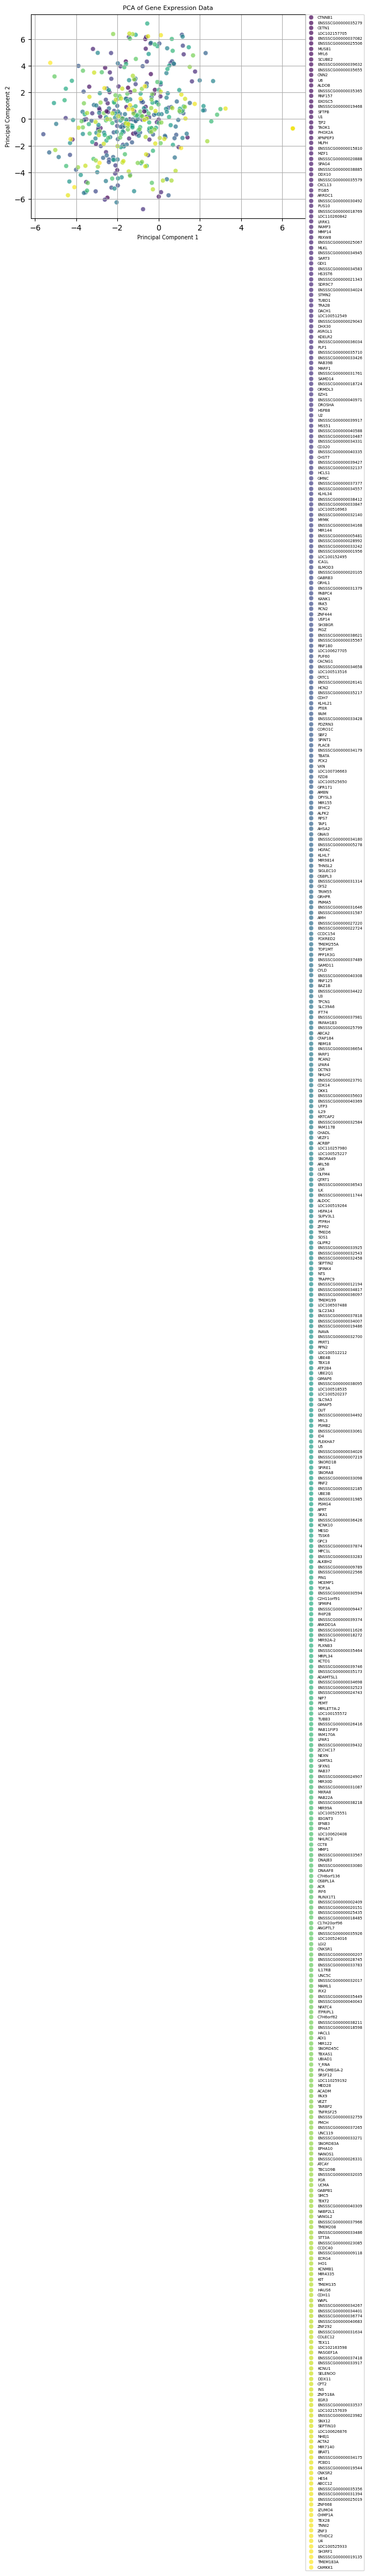

In [50]:
sample_size = 500  # Adjust as needed
if pca_df.shape[0] > sample_size:
    pca_sampled = pca_df.sample(n=sample_size, random_state=1)
else:
    pca_sampled = pca_df  # Use all data if it's less than sample_size

#limiting labels
top_genes = pca_df['Gene'].value_counts().head(10).index.tolist()  # Get top 10 genes by occurrence
pca_sampled['Label'] = np.where(pca_sampled['Gene'].isin(top_genes), pca_sampled['Gene'], '')


# Plotting with increased figure size and adjusted legend position
sns.scatterplot(data=pca_sampled, x='PC1', y='PC2', hue='Gene', legend='full', palette='viridis', alpha=0.7)

# Set plot titles and labels with reduced font size
plt.title('PCA of Gene Expression Data', fontsize=8)
plt.xlabel('Principal Component 1', fontsize=7)
plt.ylabel('Principal Component 2', fontsize=7)

# Move legend outside of the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=5)

plt.grid()

plt.show()

#### t-Distributed Stochastic Neighbor Embedding (t-SNE) Visualization

##### This section performs t-SNE to visualize the high-dimensional gene expression data. A sample of 500 data points is selected from the DataFrame (excluding the 'Gene' column) for dimensionality reduction to two components. The results are then plotted in a scatter plot, with points colored according to their corresponding gene names for easy interpretation of the clustering patterns.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/var/folders/nf/bmcsp4f521g7q_d4f_9jkgx40000gn/T/ipykernel_21862/3679130323.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


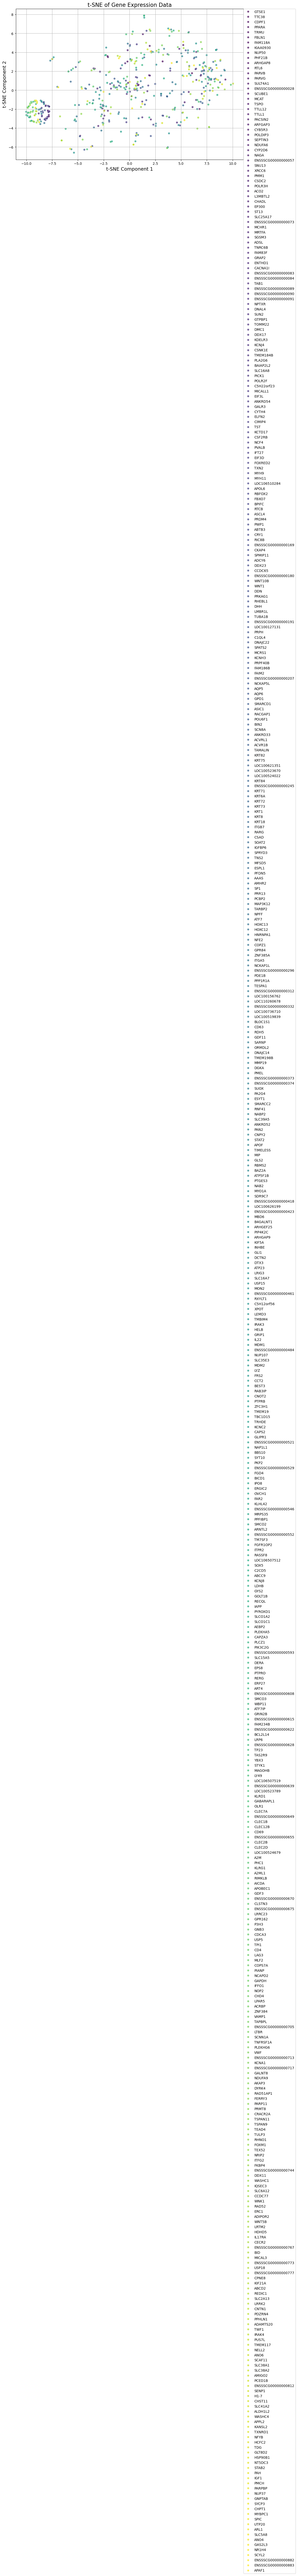

In [51]:
sample_size = 500  # Adjust as needed

tsne_sampled = data_for_tsne.sample(n=sample_size, random_state=1)


data_for_tsne = df.drop(columns=['Gene'])
tsne_sampled = data_for_tsne.sample(n=sample_size, random_state=1)
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(tsne_sampled)

# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['Gene'] = pca_df['Gene']  # Add gene names for coloring

# Plotting t-SNE
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='t-SNE1', y='t-SNE2', hue='Gene', palette='viridis', alpha=0.7)
plt.title('t-SNE of Gene Expression Data', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
plt.grid()
plt.tight_layout()
plt.show()


#### Uniform Manifold Approximation and Projection (UMAP) for Visualization

##### This section applies UMAP to the high-dimensional gene expression data to create a low-dimensional representation for visualization. A sample of data points is selected to facilitate the analysis. UMAP effectively captures the local and global structure of the data, allowing for insightful exploration of relationships and clusters within the gene expression profiles. The results can be plotted to visualize the data distribution and potential patterns among different gene expressions.


/var/folders/nf/bmcsp4f521g7q_d4f_9jkgx40000gn/T/ipykernel_21862/841577426.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


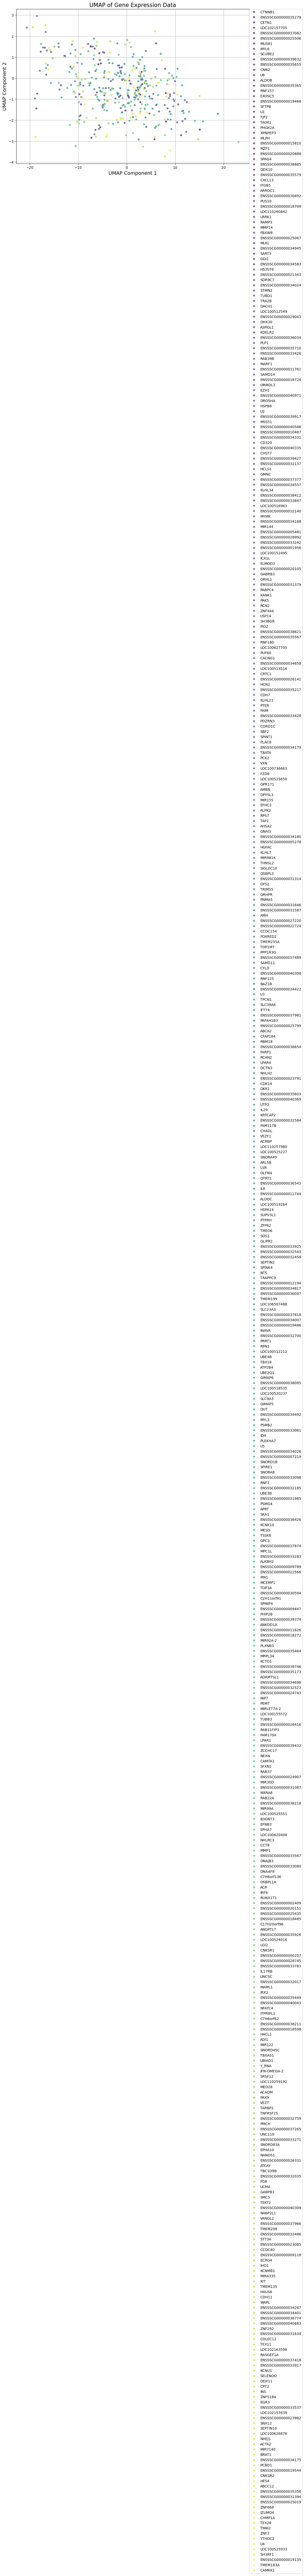

In [119]:
# Check the number of rows in the DataFrame
population_size = df.shape[0]  # Total number of rows in your DataFrame
sample_size = min(500, population_size)  # Adjust sample_size

# Drop the 'Gene' column for UMAP
data_for_lda = df.drop(columns=['Gene'])

# Sample data for UMAP
lda_sampled = data_for_lda.sample(n=sample_size, random_state=1)

# Define the target variable (Gene names)
target = df['Gene'].sample(n=sample_size, random_state=1)

# Perform UMAP
lda = LinearDiscriminantAnalysis(n_components=2)
lda_results = lda.fit_transform(lda_sampled, target)

# Create a DataFrame for UMAP results
lda_df = pd.DataFrame(lda_results, columns=['LDA1', 'LDA2'])
lda_df['Gene'] = target.values  # Add gene names for coloring

# Plotting UMAP
plt.figure(figsize=(12, 8))
sns.scatterplot(data=lda_df, x='LDA1', y='LDA2', hue='Gene', palette='viridis', alpha=0.7)
plt.title('UMAP of Gene Expression Data', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=14)
plt.ylabel('UMAP Component 2', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
plt.grid()
plt.tight_layout()
plt.show()

#### Volcano Plot for Differential Expression Analysis

##### This section generates a volcano plot to visualize the results of differential expression analysis. The plot displays the relationship between the significance (p-value) and the magnitude of change (fold change) for each gene. Genes with a significant change in expression are highlighted, enabling easy identification of upregulated and downregulated genes. The volcano plot serves as a useful tool for quickly assessing the overall landscape of gene expression changes and identifying key genes of interest.


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


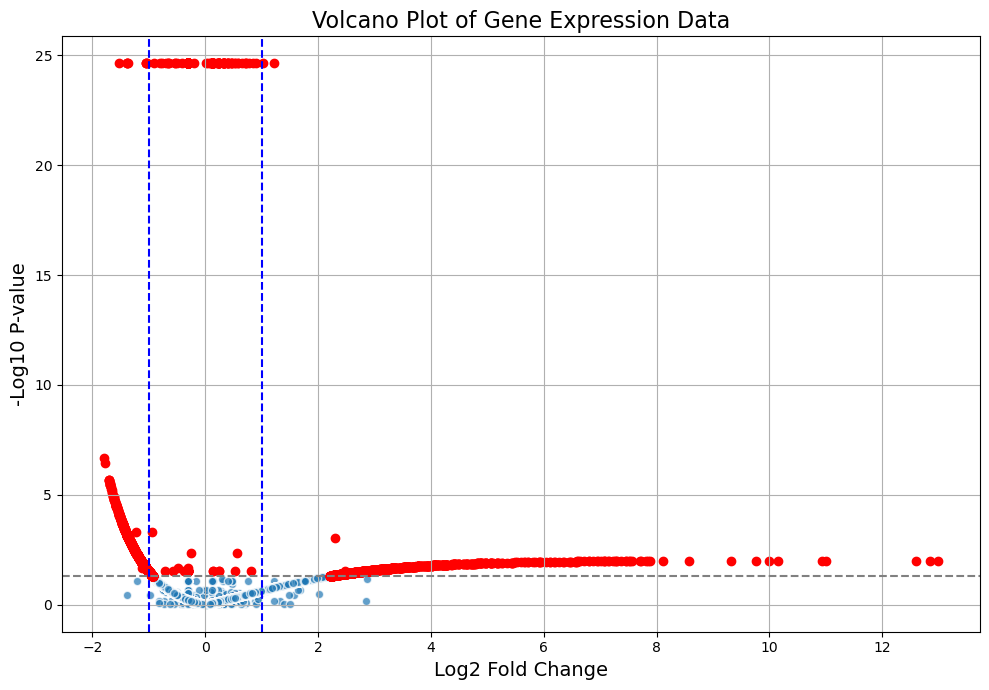

In [95]:
# Calculate means for conditions
condition1 = df.loc[:, 'ERR2239979':'ERR2239984'].mean(axis=1)
condition2 = df.loc[:, 'ERR2239985':'ERR2240050'].mean(axis=1)

# Create a new DataFrame to hold the results
results = pd.DataFrame({
    'Gene': df['Gene'],
    'Condition1': condition1,
    'Condition2': condition2
})

# Calculate log fold change safely
results['logFC'] = np.log2(results['Condition2'] + 1) - np.log2(results['Condition1'] + 1)

# Initialize the p_value list
p_values = []

# Perform a t-test for each gene
for gene in results['Gene']:
    condition1_data = df.loc[df['Gene'] == gene, 'ERR2239979':'ERR2239984'].values.flatten()
    condition2_data = df.loc[df['Gene'] == gene, 'ERR2239985':'ERR2240050'].values.flatten()
    
    # Check if both condition data arrays are not empty
    if condition1_data.size > 0 and condition2_data.size > 0:
        p_val = stats.ttest_ind(condition1_data, condition2_data, nan_policy='omit')[1]
        p_values.append(p_val)
    else:
        p_values.append(np.nan)  # Append NaN for missing data

# Assign the p-values to the results DataFrame
results['p_value'] = p_values

# Check if lengths match
if len(results) != len(p_values):
    print(f"Length mismatch: {len(results)} != {len(p_values)}")

# Calculate -log10(p-value), replacing NaN values safely
results['neg_log10_pval'] = -np.log10(results['p_value'].replace(0, np.nan))

# Create the volcano plot
plt.figure(figsize=(10, 7))
plt.scatter(results['logFC'], results['neg_log10_pval'], alpha=0.7, edgecolors='w')

# Highlight significant genes
significant = results[results['p_value'] < 0.05]  # Adjust p-value threshold as needed
plt.scatter(significant['logFC'], significant['neg_log10_pval'], color='red')

# Add lines for significance thresholds
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
plt.axvline(x=1, color='blue', linestyle='--')
plt.axvline(x=-1, color='blue', linestyle='--')

# Labeling the plot
plt.title('Volcano Plot of Gene Expression Data', fontsize=16)
plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10 P-value', fontsize=14)

plt.grid()
plt.tight_layout()
plt.show()

#### Perform differential analysis on the samples

In [80]:
# Drop rows with NaN p-values if any
results = results.dropna(subset=['p_value'])

# Group by 'Gene' and aggregate to find the minimum p-value and corresponding logFC
unique_genes = results.groupby('Gene').agg({
    'logFC': 'mean',  # You could also use 'max' or 'min' depending on your needs
    'p_value': 'min',
    'neg_log10_pval': 'max'  # Since neg_log10_pval is derived from p_value, this can be maxed too
}).reset_index()

# Sort the unique genes by p-value (ascending order)
top_genes = unique_genes.sort_values(by='p_value').head(50)

# Reset the index for clarity
top_genes.reset_index(drop=True, inplace=True)

# Display the top genes
top_genes

,Gene,logFC,p_value,neg_log10_pval
0,U6,-0.233775,2.336837e-25,24.631372
1,RXFP1,-1.799537,2.206540e-07,6.656288
2,ENSSSCG00000039344,-1.779886,3.741219e-07,6.426987
3,ENSSSCG00000037969,NaN,1.392346e-06,5.856253
4,CDH17,NaN,1.511088e-06,5.820710
5,OSBPL3,-1.710952,2.064848e-06,5.685112
6,EPHB6,-1.710824,2.070992e-06,5.683822
7,HTRA3,-1.709762,2.122739e-06,5.673103
8,CAPN1,-1.703213,2.469112e-06,5.607459
9,SLC26A2,-1.693717,3.064577e-06,5.513630


#### Extract the list of significantly differentially expressed genes, and generate a heatmap showing only those genes

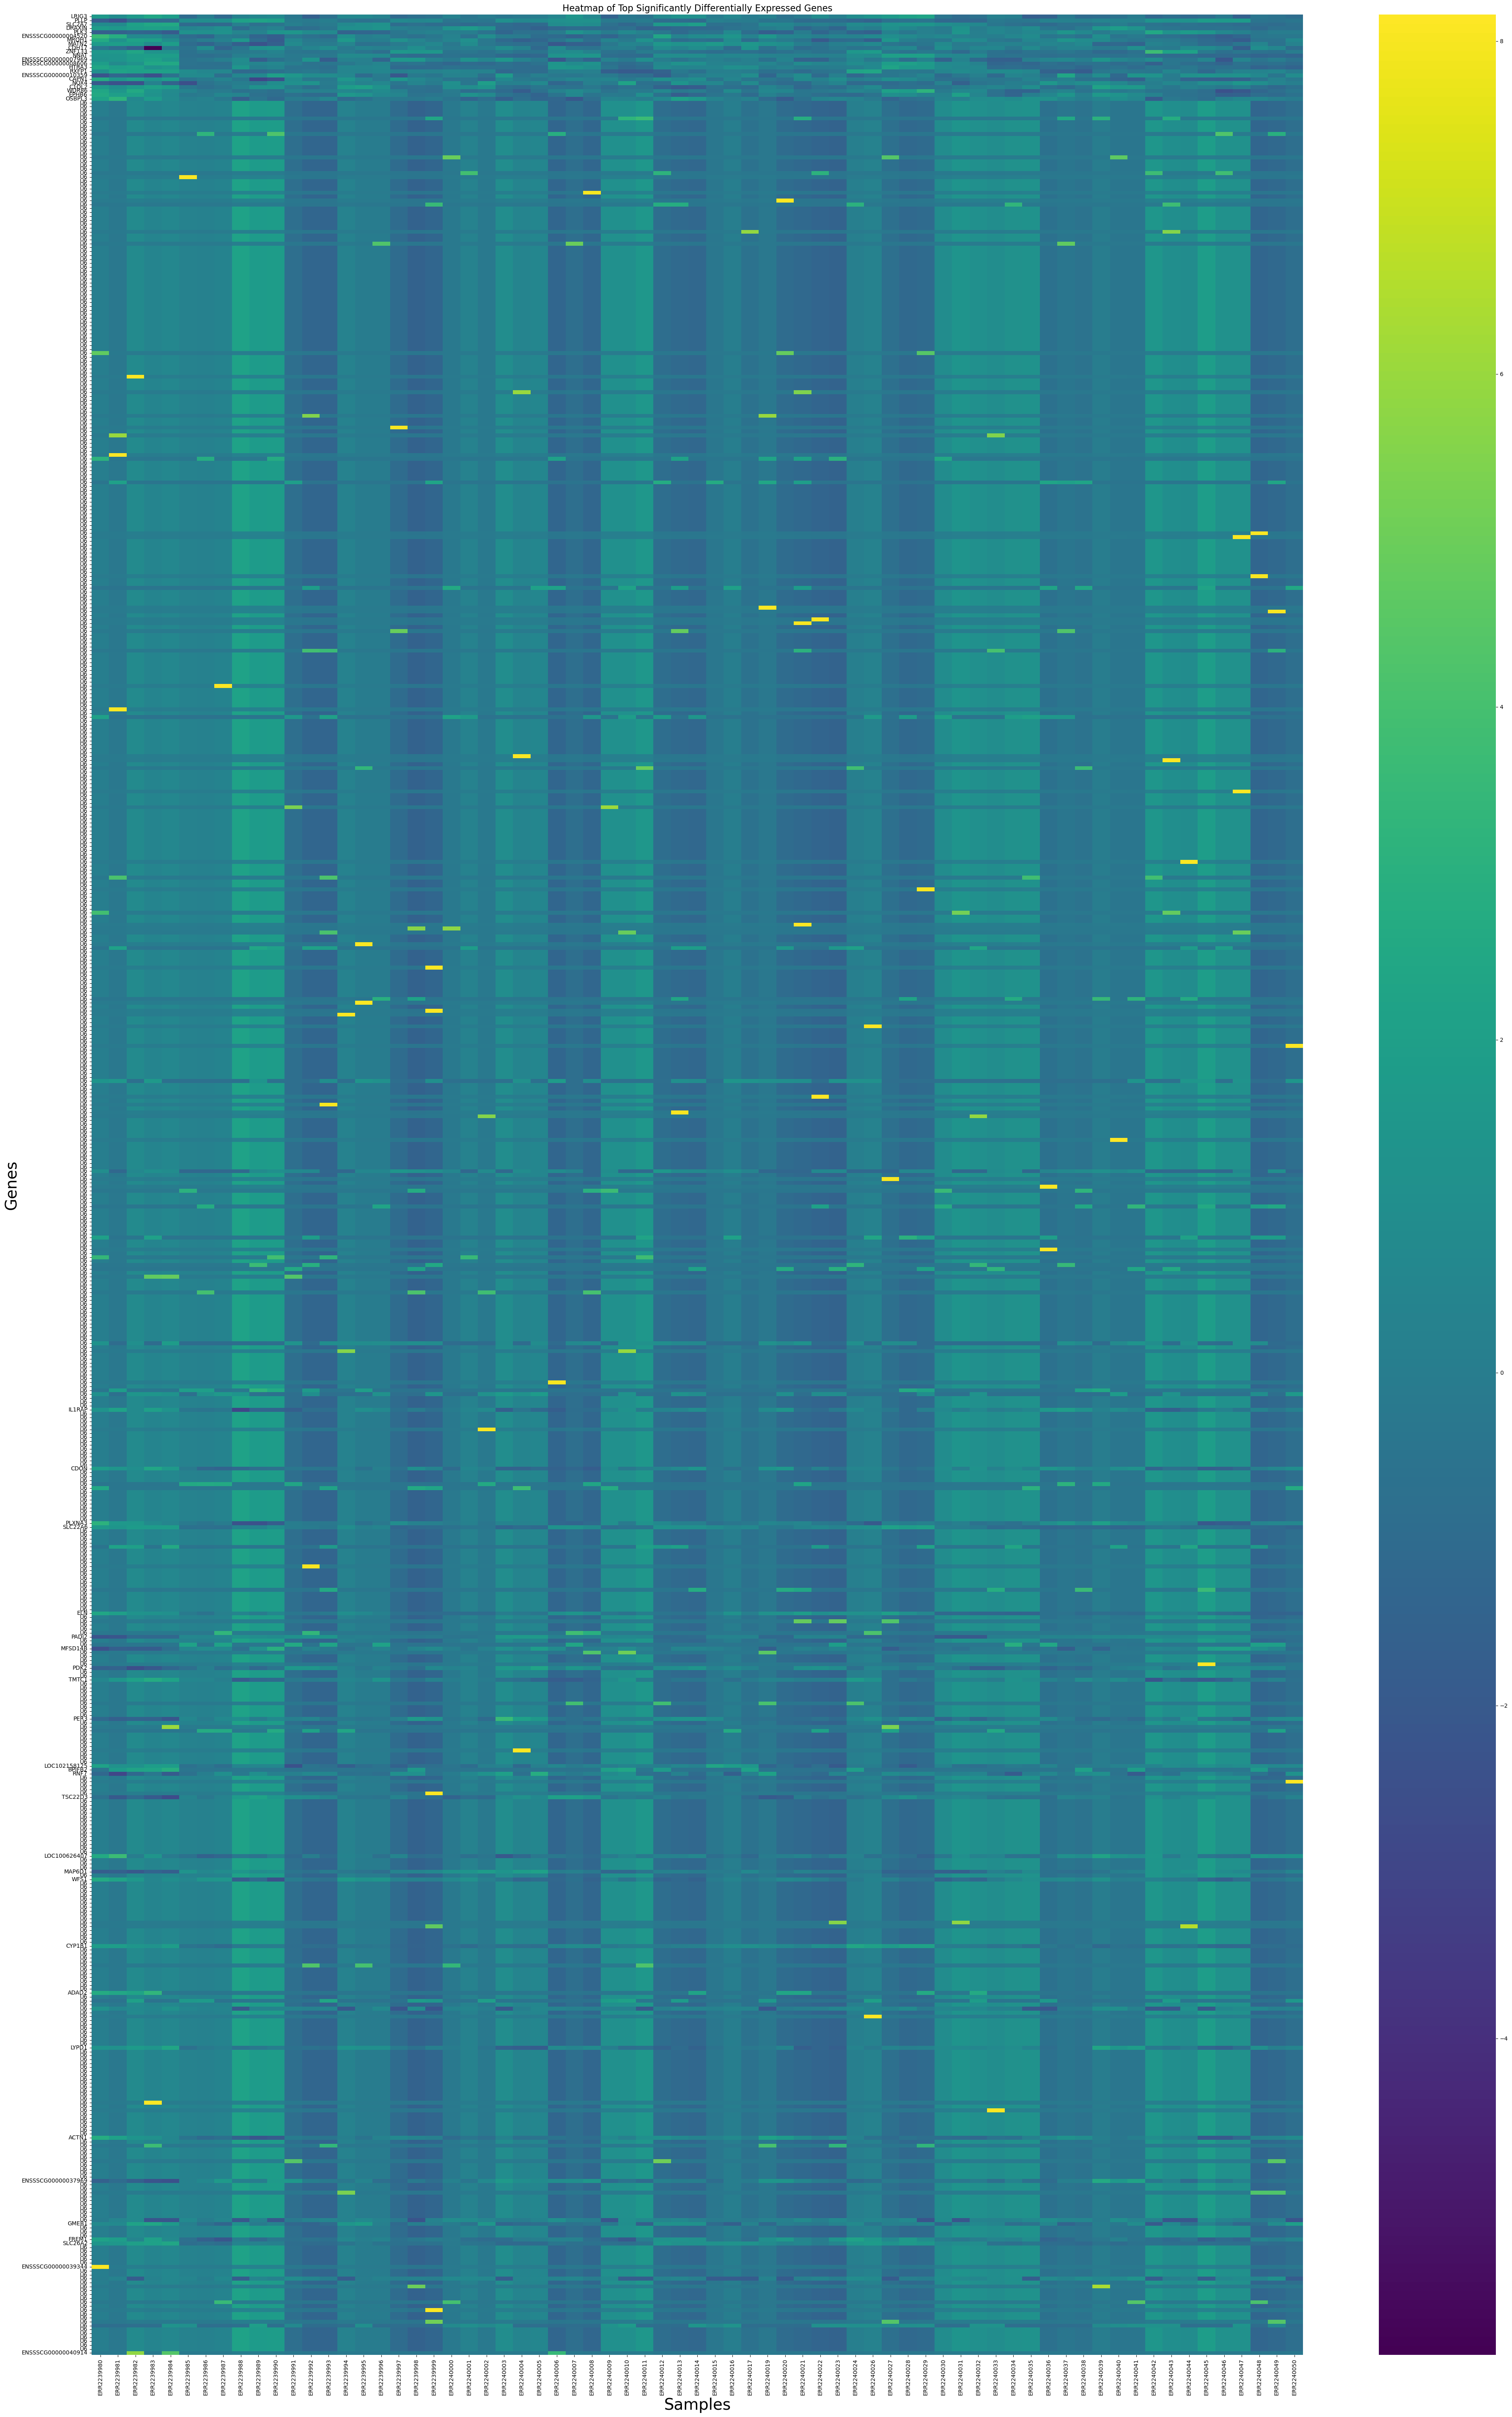

In [76]:
# Extract significantly differentially expressed genes
significant_genes = results[results['p_value'] < 0.05]

# Sort by p-value and get the top 50 unique genes
top_genes = significant_genes.sort_values(by='p_value').drop_duplicates(subset='Gene').head(50)

# Extract the gene names for the heatmap
gene_names = top_genes['Gene'].values

# Prepare data for the heatmap
# Filter the original DataFrame to get expression data for significant genes
heatmap_data = df[df['Gene'].isin(gene_names)].set_index('Gene')

# normalize the data (z-score normalization)
heatmap_data_normalized = (heatmap_data.iloc[:, 1:].subtract(heatmap_data.iloc[:, 1:].mean(axis=1), axis=0)
                           .divide(heatmap_data.iloc[:, 1:].std(axis=1, ddof=0), axis=0))

# Generate the heatmap
plt.figure(figsize=(40, 60))
sns.heatmap(heatmap_data_normalized, cmap='viridis', annot=False, cbar=True, xticklabels=1, yticklabels=True)

# Add labels and title
plt.title('Heatmap of Top Significantly Differentially Expressed Genes', fontsize=16)
plt.xlabel('Samples', fontsize=28)
plt.ylabel('Genes', fontsize=28)

# Show the plot
plt.tight_layout()
plt.show()

#### Extract the list of differentially expressed genes and run gene set enrichment analysis

In [101]:
# Prepare the ranked list of genes based on log fold change
results['rank'] = results['logFC'].rank(method='max', ascending=False)

# Impute missing values in logFC
imputer = SimpleImputer(strategy='mean')  # You can choose 'median' or other strategies
results[['logFC']] = imputer.fit_transform(results[['logFC']])

# Define your gene sets using only numerical data for clustering
numeric_data = results[['logFC']]

kmeans = KMeans(n_clusters=3, random_state=0).fit(numeric_data)
clusters = kmeans.labels_

# Create gene sets based on clusters
gene_sets = {}
for gene, cluster in zip(results['Gene'], clusters):
    if cluster not in gene_sets:
        gene_sets[cluster] = []
    gene_sets[cluster].append(gene)

# Step 3: Perform the Wilcoxon rank-sum test for each gene set
enrichment_results = []

for gene_set_name, gene_set in gene_sets.items():
    # Extract the ranks for the gene set
    set_ranks = results.loc[results['Gene'].isin(gene_set), 'rank']
    
    # Perform Wilcoxon rank-sum test against the background (all genes)
    if len(set_ranks) > 0:
        stat, p_value = stats.ranksums(set_ranks, results['rank'])
        enrichment_results.append({
            'Gene Set': gene_set_name,
            'Wilcoxon Statistic': stat,
            'P-value': p_value
        })

# Convert to DataFrame for easier analysis
enrichment_df = pd.DataFrame(enrichment_results)

# Analyze results with Benjamini-Hochberg adjustment
# Sort p-values and prepare for adjustment
enrichment_df['P-value'] = pd.to_numeric(enrichment_df['P-value'], errors='coerce')
m = len(enrichment_df)  # Total number of tests
enrichment_df = enrichment_df.sort_values('P-value')
enrichment_df['Rank'] = np.arange(1, m + 1)
enrichment_df['Adjusted P-value'] = (enrichment_df['P-value'] * m) / enrichment_df['Rank']

# Ensure adjusted p-values do not exceed 1
enrichment_df['Adjusted P-value'] = enrichment_df['Adjusted P-value'].clip(upper=1)

# Filter for significant results (adjust the threshold as needed)
significant_results = enrichment_df[enrichment_df['Adjusted P-value'] < 0.05]

# Display the results
print(significant_results)

enrichment_df.to_csv('Julian_Wilcoxon_rank-sum_enrichment_analysis_results.csv', index=False)


   Gene Set  Wilcoxon Statistic  P-value  Rank  Adjusted P-value
0         0          -69.071482      0.0     1               0.0
1         2           71.268601      0.0     2               0.0
2         1          -56.165400      0.0     3               0.0
